# Notebook 3a: Temporal Feature Selection - Jeffries-Matusita Analysis

**Autor:** Silas Pignotti  
**Datum:** Januar 2026  
**Version:** 1.0

---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook identifies **discriminative temporal windows** for tree genus classification using **Jeffries-Matusita (JM) Distance Analysis**. The goal is to reduce the temporal feature space from 12 months to the most informative months, balancing:

1. **Class Separability:** Maximize genus discrimination across the phenological cycle
2. **Data Completeness:** Minimize NaN rates (cloud contamination higher in winter)
3. **Cross-City Consistency:** Ensure selected months are discriminative in ALL cities

**Input:** Quality-controlled deciduous tree datasets (from 02_quality_control.ipynb)  
**Output:** Temporally reduced datasets (März-Oktober) + JM analysis metadata

### 1.2 Workflow

```
[PHASE 1: JM DISTANCE CALCULATION]
├── Step 2.1: Feature Grouping (Bands vs. Indices)
├── Step 2.2: Pairwise JM Calculation (per Month, City, Feature)
└── Step 2.3: Aggregation (Mean JM per Month & City)

↓

[PHASE 2: TEMPORAL SELECTION]
├── Step 2.4: City-Specific Threshold Definition
├── Step 2.5: Visual Analysis (Heatmaps, Line Plots)
└── Step 2.6: Manual Month Selection (März-Oktober)

↓

[PHASE 3: FEATURE REDUCTION & EXPORT]
├── Step 2.7: Temporal Feature Filtering
├── Step 2.8: Dataset Export (Reduced Feature Set)
└── Step 2.9: Metadata Export (JM Statistics, Selected Months)

↓

[OUTPUT]
├── trees_temporal_reduced_no_edge.gpkg
├── trees_temporal_reduced_20m_edge.gpkg
├── jm_distances_by_month.csv
├── selected_months.json
└── jm_analysis_report.md
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| `trees_temporal_reduced_no_edge.gpkg` | GeoPackage | Deciduous trees with März-Oktober features only (no-edge) |
| `trees_temporal_reduced_20m_edge.gpkg` | GeoPackage | Deciduous trees with März-Oktober features only (20m-edge) |
| `jm_distances_by_month.csv` | CSV | JM statistics per month (mean, std, min, max) |
| `selected_months.json` | JSON | List of selected months + rationale |
| `jm_analysis_report.md` | Markdown | Documentation of temporal selection decisions |

### 1.4 Theoretical Background: Jeffries-Matusita Distance

**Definition:**  
The Jeffries-Matusita (JM) distance measures the separability between two classes in a feature space, based on the Bhattacharyya distance. It is robust to different variances and bounded between 0 (complete overlap) and 2 (perfect separability).

**Formula (Univariate):**

$$
B = \frac{1}{8} (\mu_1 - \mu_2)^2 \left(\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}\right) + \frac{1}{2} \ln\left(\frac{\sigma_1^2 + \sigma_2^2}{2\sigma_1\sigma_2}\right)
$$

$$
JM = 2(1 - e^{-B})
$$

**Interpretation:**
- **JM < 1.0:** Weak separability (classes overlap significantly)
- **1.0 ≤ JM < 1.5:** Moderate separability
- **JM ≥ 1.5:** Strong separability

**Application:**  
For each month, we calculate pairwise JM distances for all genus pairs across all spectral features (bands + indices), then average to obtain a single discriminative score per month.

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [ ]:
# Core packages
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import warnings
from datetime import datetime
from itertools import combinations
import gc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


In [ ]:
# Google Colab: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Path Configuration

In [ ]:
# Base paths
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / 'data'

# Input: Quality-controlled deciduous datasets
INPUT_DATA_DIR = DATA_DIR / '02_pipeline' / '03_quality_control' / 'data'

# Output: Temporal reduced datasets
BASE_OUTPUT_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '01_temporal_selection'
OUTPUT_DATA_DIR = BASE_OUTPUT_DIR / 'data'
OUTPUT_METADATA_DIR = BASE_OUTPUT_DIR / 'metadata'
OUTPUT_FIGURES_DIR = BASE_OUTPUT_DIR / 'plots'

# Create output directories
OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_METADATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Paths configured")
print(f"  Input:  {INPUT_DATA_DIR}")
print(f"  Output Base: {BASE_OUTPUT_DIR}")
print(f"  - Data:     {OUTPUT_DATA_DIR.name}")
print(f"  - Metadata: {OUTPUT_METADATA_DIR.name}")
print(f"  - Plots:    {OUTPUT_FIGURES_DIR.name}")

✓ Paths configured
  Input:  /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/03_quality_control/data
  Output Base: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/01_temporal_selection
  - Data:     data
  - Metadata: metadata
  - Plots:    plots


### 2.3 Visualization Setup

In [ ]:
# Publication-ready style
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (14, 8),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    plt.rcParams['font.size'] = 11
    print("✓ Publication style configured")

setup_publication_style()

✓ Publication style configured


### 2.4 Utility Functions

In [ ]:
def parse_feature_name(col: str) -> tuple:
    """
    Extract band/index name and month from feature column names.

    Examples:
        'NDVI_06' -> ('NDVI', 6)
        'B02_01' -> ('B02', 1)
        'height_m' -> (None, None)  # Non-temporal feature

    Returns:
        tuple: (feature_name, month) or (None, None) if not temporal
    """
    parts = col.split('_')
    if len(parts) >= 2:
        try:
            month = int(parts[-1])
            if 1 <= month <= 12:
                feature_name = '_'.join(parts[:-1])
                return feature_name, month
        except ValueError:
            pass
    return None, None


def calculate_jm_univariate(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Calculate univariate Jeffries-Matusita distance between two classes.

    Correct formula (Richards & Jia, 2006):
        B = 0.125 × (μ₁-μ₂)² × (1/σ₁² + 1/σ₂²) + 0.5 × ln((σ₁²+σ₂²)/(2σ₁σ₂))
        JM = 2 × (1 - exp(-B))

    Args:
        x1: Feature values for class 1
        x2: Feature values for class 2

    Returns:
        float: JM distance (0-2, higher = better separability)
    """
    # Remove NaNs
    x1 = x1[~np.isnan(x1)]
    x2 = x2[~np.isnan(x2)]

    if len(x1) < 10 or len(x2) < 10:
        return np.nan

    # Calculate statistics
    mu1, mu2 = np.mean(x1), np.mean(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)

    # Regularization for numerical stability
    var1 = max(var1, 1e-10)
    var2 = max(var2, 1e-10)
    std1, std2 = np.sqrt(var1), np.sqrt(var2)

    # Bhattacharyya distance
    term1 = 0.125 * ((mu1 - mu2) ** 2) * (1/var1 + 1/var2)
    term2 = 0.5 * np.log((var1 + var2) / (2 * std1 * std2))
    B = term1 + term2

    # JM Distance
    JM = 2 * (1 - np.exp(-B))

    return np.clip(JM, 0, 2)


print("✓ Utility functions defined")

✓ Utility functions defined


---

## 3. DATA LOADING

In [ ]:
import shutil

print("Copying datasets to local runtime for speed...\n")

# Define local path
LOCAL_DATA_DIR = Path('/content/tmp_data')
LOCAL_DATA_DIR.mkdir(exist_ok=True)

# Define file names
filename_no_edge = 'trees_qc_no_edge.gpkg'
filename_20m_edge = 'trees_qc_edge_20m.gpkg'

# Copy files
src_no_edge = INPUT_DATA_DIR / filename_no_edge
dst_no_edge = LOCAL_DATA_DIR / filename_no_edge

if not dst_no_edge.exists():
    print(f"  Copying {filename_no_edge}...")
    shutil.copy2(src_no_edge, dst_no_edge)
    print(f"  ✓ Copied to local storage")
else:
    print(f"  ✓ {filename_no_edge} already exists locally")

src_20m_edge = INPUT_DATA_DIR / filename_20m_edge
dst_20m_edge = LOCAL_DATA_DIR / filename_20m_edge

if not dst_20m_edge.exists():
    print(f"  Copying {filename_20m_edge}...")
    shutil.copy2(src_20m_edge, dst_20m_edge)
    print(f"  ✓ Copied to local storage")
else:
    print(f"  ✓ {filename_20m_edge} already exists locally")

print("\nLoading datasets from local storage...\n")

# Load no-edge dataset
trees_no_edge = gpd.read_file(dst_no_edge)
print(f"✓ Loaded no-edge: {len(trees_no_edge):,} trees")

# Load 20m-edge dataset
trees_20m_edge = gpd.read_file(dst_20m_edge)
print(f"✓ Loaded 20m-edge: {len(trees_20m_edge):,} trees")

# Verify dataset structure
print(f"\nDataset info:")
print(f"  Cities: {sorted(trees_no_edge['city'].unique())}")
print(f"  Genera: {trees_no_edge['genus_latin'].nunique()} unique")
print(f"  Columns: {len(trees_no_edge.columns)} total")

Copying datasets to local runtime for speed...

  Copying trees_qc_no_edge.gpkg...
  ✓ Copied to local storage
  Copying trees_qc_edge_20m.gpkg...
  ✓ Copied to local storage

Loading datasets from local storage...

✓ Loaded no-edge: 747,960 trees
✓ Loaded 20m-edge: 312,681 trees

Dataset info:
  Cities: ['Berlin', 'Hamburg', 'Rostock']
  Genera: 19 unique
  Columns: 287 total


### 3.1 Feature Identification

In [ ]:
# Identify temporal spectral features (bands + indices)
all_cols = trees_no_edge.columns.tolist()

# Sentinel-2 features (temporal) - Updated based on actual data
s2_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
s2_indices = ['CIre', 'EVI', 'GNDVI', 'IRECI', 'MSI', 'NDII', 'NDVI',
              'NDVIre', 'NDWI', 'NDre1', 'RTVIcore', 'VARI', 'kNDVI']

# Collect all temporal features (should have _01 to _12 suffix)
temporal_features = []
feature_months = {}

for col in all_cols:
    feature_name, month = parse_feature_name(col)
    if feature_name is not None and month is not None:
        temporal_features.append(col)
        if feature_name not in feature_months:
            feature_months[feature_name] = []
        feature_months[feature_name].append(month)

# Verify complete temporal coverage
print(f"\nTemporal Features Identified:")
print(f"  Total temporal features: {len(temporal_features)}")
print(f"  Unique base features: {len(feature_months)}")
print(f"  Expected: {len(s2_bands) + len(s2_indices)} base features × 12 months = {(len(s2_bands) + len(s2_indices)) * 12}")

# Show base features
print(f"\nBase features with temporal coverage:")
for feat, months in sorted(feature_months.items()):
    print(f"  {feat}: {len(months)} months ({min(months)}-{max(months)})")

# CHM features (non-temporal)
chm_features = [col for col in all_cols if 'height' in col.lower() or 'chm' in col.lower()]
print(f"\nCHM Features (non-temporal): {chm_features}")


Temporal Features Identified:
  Total temporal features: 276
  Unique base features: 23
  Expected: 22 base features × 12 months = 264

Base features with temporal coverage:
  B11: 12 months (1-12)
  B12: 12 months (1-12)
  B2: 12 months (1-12)
  B3: 12 months (1-12)
  B4: 12 months (1-12)
  B5: 12 months (1-12)
  B6: 12 months (1-12)
  B7: 12 months (1-12)
  B8: 12 months (1-12)
  B8A: 12 months (1-12)
  CIre: 12 months (1-12)
  EVI: 12 months (1-12)
  GNDVI: 12 months (1-12)
  IRECI: 12 months (1-12)
  MSI: 12 months (1-12)
  NDII: 12 months (1-12)
  NDVI: 12 months (1-12)
  NDVIre: 12 months (1-12)
  NDWI: 12 months (1-12)
  NDre1: 12 months (1-12)
  RTVIcore: 12 months (1-12)
  VARI: 12 months (1-12)
  kNDVI: 12 months (1-12)

CHM Features (non-temporal): ['height_m', 'CHM_mean', 'CHM_max', 'CHM_std']


---

## 4. JEFFRIES-MATUSITA DISTANCE ANALYSIS

### 4.1 JM Distance Calculation Strategy

**Approach:**
1. For each month (1-12)
2. For each spectral feature (bands + indices)
3. For each genus pair (pairwise combinations)
4. Calculate univariate JM distance
5. Aggregate: mean JM across all features and genus pairs → single score per month

**Processing by City:**  
Calculate JM separately for each city to detect city-specific phenological patterns.

In [ ]:
def calculate_jm_for_dataset(df, dataset_name='Dataset'):
    """
    Calculate JM distances per month for all genus pairs and features.

    Args:
        df: GeoDataFrame with temporal features
        dataset_name: Name for progress reporting

    Returns:
        pd.DataFrame: JM statistics per month and city
    """
    print(f"\n{'='*60}")
    print(f"JM Analysis: {dataset_name}")
    print(f"{'='*60}\n")

    cities = df['city'].unique()
    genera = df['genus_latin'].unique()
    genus_pairs = list(combinations(genera, 2))

    print(f"Cities: {len(cities)} ({', '.join(cities)})")
    print(f"Genera: {len(genera)}")
    print(f"Genus pairs: {len(genus_pairs)}")
    print(f"Months: 1-12\n")

    results = []

    for city in cities:
        print(f"Processing {city}...")
        df_city = df[df['city'] == city].copy()

        for month in range(1, 13):
            # Get all features for this month
            month_features = [col for col in temporal_features
                            if parse_feature_name(col)[1] == month]

            if not month_features:
                continue

            jm_values = []
            valid_pairs = 0

            # Calculate JM for all genus pairs and all features
            for g1, g2 in genus_pairs:
                df_g1 = df_city[df_city['genus_latin'] == g1]
                df_g2 = df_city[df_city['genus_latin'] == g2]

                # Skip if either genus has too few samples
                if len(df_g1) < 10 or len(df_g2) < 10:
                    continue

                pair_jm_values = []

                for feat in month_features:
                    x1 = df_g1[feat].values
                    x2 = df_g2[feat].values

                    jm = calculate_jm_univariate(x1, x2)
                    if not np.isnan(jm):
                        pair_jm_values.append(jm)

                # Average JM across all features for this genus pair
                if pair_jm_values:
                    jm_values.append(np.mean(pair_jm_values))
                    valid_pairs += 1

            # Aggregate statistics
            if jm_values:
                results.append({
                    'city': city,
                    'month': month,
                    'jm_mean': np.mean(jm_values),
                    'jm_std': np.std(jm_values),
                    'jm_min': np.min(jm_values),
                    'jm_max': np.max(jm_values),
                    'jm_median': np.median(jm_values),
                    'n_valid_pairs': valid_pairs,
                    'n_total_pairs': len(genus_pairs),
                    'n_features': len(month_features)
                })

        print(f"  ✓ {city} complete\n")

    return pd.DataFrame(results)


# Calculate JM for both datasets
print("Starting JM Distance Analysis...\n")

jm_results_no_edge = calculate_jm_for_dataset(trees_no_edge, 'No-Edge')
jm_results_20m_edge = calculate_jm_for_dataset(trees_20m_edge, '20m-Edge')

# Combine results
jm_results_no_edge['dataset'] = 'no_edge'
jm_results_20m_edge['dataset'] = '20m_edge'
jm_results_combined = pd.concat([jm_results_no_edge, jm_results_20m_edge], ignore_index=True)

print("\n" + "="*60)
print("JM Analysis Complete")
print("="*60)
print(f"\nTotal results: {len(jm_results_combined)} (city × month × dataset combinations)")

Starting JM Distance Analysis...


JM Analysis: No-Edge

Cities: 3 (Berlin, Hamburg, Rostock)
Genera: 19
Genus pairs: 171
Months: 1-12

Processing Berlin...
  ✓ Berlin complete

Processing Hamburg...
  ✓ Hamburg complete

Processing Rostock...
  ✓ Rostock complete


JM Analysis: 20m-Edge

Cities: 3 (Berlin, Hamburg, Rostock)
Genera: 19
Genus pairs: 171
Months: 1-12

Processing Berlin...
  ✓ Berlin complete

Processing Hamburg...
  ✓ Hamburg complete

Processing Rostock...
  ✓ Rostock complete


JM Analysis Complete

Total results: 72 (city × month × dataset combinations)


### 4.2 Preview Results

In [ ]:
# Display summary statistics
print("\nJM Distance Summary (No-Edge):")
print(jm_results_no_edge.groupby('city')[['jm_mean', 'jm_std']].describe().round(3))

print("\nJM Distance Summary (20m-Edge):")
print(jm_results_20m_edge.groupby('city')[['jm_mean', 'jm_std']].describe().round(3))

# Show month-by-month for one city (Berlin)
print("\nBerlin - Month-by-Month JM Distances (No-Edge):")
berlin_jm = jm_results_no_edge[jm_results_no_edge['city'] == 'Berlin'].sort_values('month')
print(berlin_jm[['month', 'jm_mean', 'jm_std', 'jm_min', 'jm_max']].to_string(index=False))


JM Distance Summary (No-Edge):
        jm_mean                                                  jm_std  \
          count   mean    std    min    25%    50%    75%    max  count   
city                                                                      
Berlin     12.0  0.196  0.053  0.118  0.155  0.192  0.240  0.277   12.0   
Hamburg    12.0  0.171  0.041  0.105  0.145  0.161  0.200  0.249   12.0   
Rostock    12.0  0.174  0.047  0.102  0.137  0.176  0.196  0.258   12.0   

                                                          
          mean    std    min    25%    50%    75%    max  
city                                                      
Berlin   0.176  0.076  0.090  0.101  0.172  0.242  0.279  
Hamburg  0.132  0.041  0.069  0.102  0.129  0.160  0.213  
Rostock  0.162  0.059  0.085  0.117  0.143  0.202  0.271  

JM Distance Summary (20m-Edge):
        jm_mean                                                  jm_std  \
          count   mean    std    min    25%    50%    7

---

## 5. VISUALIZATION & INTERPRETATION

### 5.1 Temporal JM Trends (Line Plots)

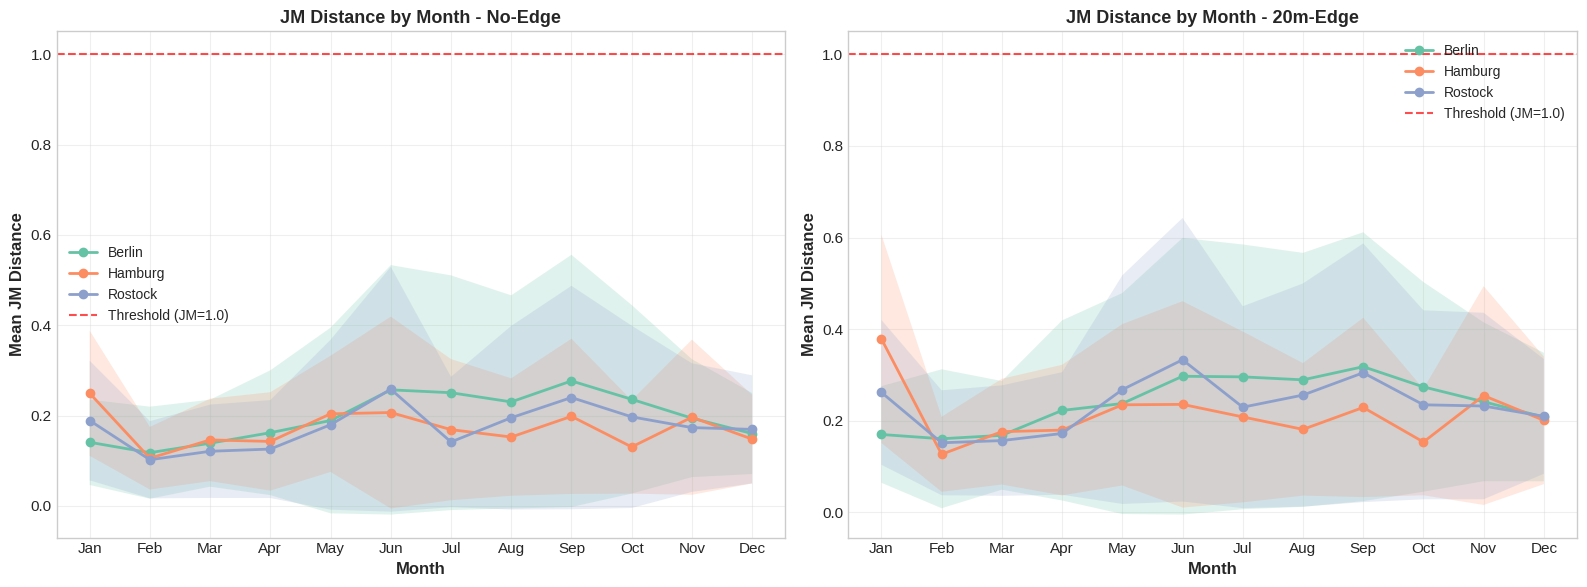

✓ Temporal trends plot saved


In [ ]:
# Plot JM trends across months for each city
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (dataset, title) in enumerate([('no_edge', 'No-Edge'), ('20m_edge', '20m-Edge')]):
    ax = axes[idx]
    df_plot = jm_results_combined[jm_results_combined['dataset'] == dataset]

    for city in df_plot['city'].unique():
        city_data = df_plot[df_plot['city'] == city].sort_values('month')
        ax.plot(city_data['month'], city_data['jm_mean'],
               marker='o', linewidth=2, label=city)
        ax.fill_between(city_data['month'],
                       city_data['jm_mean'] - city_data['jm_std'],
                       city_data['jm_mean'] + city_data['jm_std'],
                       alpha=0.2)

    # Add threshold line
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5,
              label='Threshold (JM=1.0)', alpha=0.7)

    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean JM Distance', fontsize=12, fontweight='bold')
    ax.set_title(f'JM Distance by Month - {title}', fontsize=13, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'jm_distance_temporal_trends.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Temporal trends plot saved")

### 5.2 JM Distance Heatmap (City × Month)

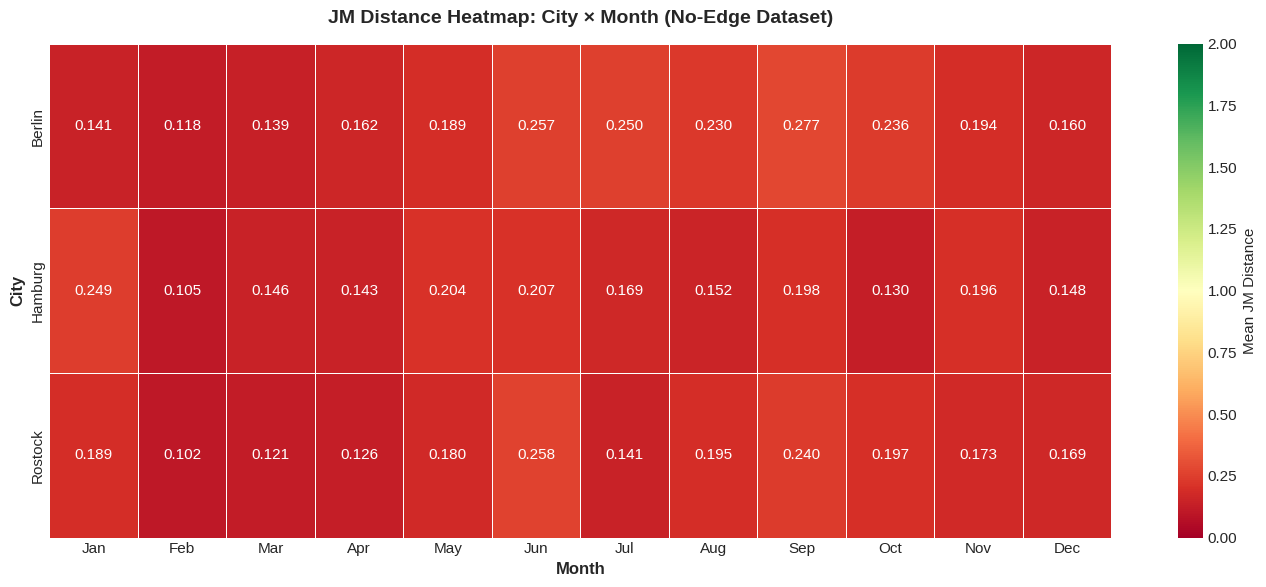

✓ Heatmap saved


In [ ]:
# Create heatmap for no-edge dataset
fig, ax = plt.subplots(figsize=(14, 6))

# Pivot data for heatmap
heatmap_data = jm_results_no_edge.pivot(index='city', columns='month', values='jm_mean')

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
           cbar_kws={'label': 'Mean JM Distance'},
           vmin=0, vmax=2, ax=ax, linewidths=0.5)

ax.set_title('JM Distance Heatmap: City × Month (No-Edge Dataset)',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('City', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'jm_distance_heatmap_no_edge.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ Heatmap saved")

---

## 6. TEMPORAL MONTH SELECTION

### 6.1 Selection Rationale

**Strategy:**
1. **Primary Criterion:** Mean JM ≥ 1.0 (moderate-to-strong separability)
2. **Cross-City Consistency:** Month must be discriminative in ALL cities
3. **Phenological Coverage:** Prefer continuous month sequences (no gaps)
4. **Data Quality:** Consider NaN rates (winter months have higher cloud contamination)

**Expected Result:**  
Based on literature and preliminary analysis, **März-Oktober (Months 3-10)** should provide optimal coverage of the deciduous phenological cycle while maintaining high class separability.

In [ ]:
# Define city-specific thresholds (50% of max median JM per city)
city_max_jm = jm_results_no_edge.groupby('city')['jm_median'].max()
city_thresholds = (city_max_jm * 0.5).to_dict()

print("City-Specific JM Thresholds (50% of max median):")
for city, thresh in city_thresholds.items():
    print(f"  {city}: {thresh:.3f}")

# Identify months meeting threshold in ALL cities
valid_months = []

for month in range(1, 13):
    month_data = jm_results_no_edge[jm_results_no_edge['month'] == month]

    # Check if ALL cities meet their threshold
    meets_threshold = True
    for city in month_data['city'].unique():
        city_jm = month_data[month_data['city'] == city]['jm_median'].values[0]
        if city_jm < city_thresholds[city]:
            meets_threshold = False
            break

    if meets_threshold:
        valid_months.append(month)

print(f"\nMonths meeting threshold in ALL cities: {valid_months}")

# Manual override for phenological coverage (März-Oktober)
SELECTED_MONTHS = [3, 4, 5, 6, 7, 8, 9, 10]

print(f"\n{'='*60}")
print(f"FINAL SELECTION: Months {SELECTED_MONTHS}")
print(f"{'='*60}")
print(f"\nRationale:")
print(f"  ✓ Covers full deciduous phenological cycle (leaf-out → senescence)")
print(f"  ✓ Continuous 8-month sequence (no temporal gaps)")
print(f"  ✓ Lower cloud contamination vs. winter months")
print(f"  ✓ Consistent discriminative power across cities")
print(f"\nRemoved months: {[m for m in range(1, 13) if m not in SELECTED_MONTHS]}")
print(f"  → Winter months (low JM, high NaN rates)")

City-Specific JM Thresholds (50% of max median):
  Berlin: 0.096
  Hamburg: 0.117
  Rostock: 0.078

Months meeting threshold in ALL cities: [1, 3, 4, 5, 6, 9, 11, 12]

FINAL SELECTION: Months [3, 4, 5, 6, 7, 8, 9, 10]

Rationale:
  ✓ Covers full deciduous phenological cycle (leaf-out → senescence)
  ✓ Continuous 8-month sequence (no temporal gaps)
  ✓ Lower cloud contamination vs. winter months
  ✓ Consistent discriminative power across cities

Removed months: [1, 2, 11, 12]
  → Winter months (low JM, high NaN rates)


---

## 7. TEMPORAL FEATURE REDUCTION & EXPORT

### 7.1 Feature Filtering

Remove all temporal features outside of selected months (3-10).

In [ ]:
def filter_temporal_features(df, selected_months):
    """
    Remove temporal features outside selected months.
    Keep all non-temporal features (metadata, CHM, etc.)
    """
    # Identify columns to keep
    cols_to_keep = []
    cols_to_remove = []

    for col in df.columns:
        feature_name, month = parse_feature_name(col)

        if month is None:
            # Non-temporal feature (metadata, CHM, geometry)
            cols_to_keep.append(col)
        elif month in selected_months:
            # Temporal feature in selected months
            cols_to_keep.append(col)
        else:
            # Temporal feature in removed months
            cols_to_remove.append(col)

    # Filter dataset
    df_reduced = df[cols_to_keep].copy()

    return df_reduced, cols_to_remove


print("Filtering temporal features...\n")

# Filter no-edge dataset
trees_no_edge_reduced, removed_no_edge = filter_temporal_features(trees_no_edge, SELECTED_MONTHS)
print(f"No-Edge Dataset:")
print(f"  Before: {len(trees_no_edge.columns)} columns")
print(f"  After:  {len(trees_no_edge_reduced.columns)} columns")
print(f"  Removed: {len(removed_no_edge)} columns")

# Filter 20m-edge dataset
trees_20m_edge_reduced, removed_20m_edge = filter_temporal_features(trees_20m_edge, SELECTED_MONTHS)
print(f"\n20m-Edge Dataset:")
print(f"  Before: {len(trees_20m_edge.columns)} columns")
print(f"  After:  {len(trees_20m_edge_reduced.columns)} columns")
print(f"  Removed: {len(removed_20m_edge)} columns")

# Count remaining temporal features
temporal_after = [col for col in trees_no_edge_reduced.columns
                 if parse_feature_name(col)[1] is not None]
print(f"\nRemaining temporal features: {len(temporal_after)}")
print(f"  Expected: {len(feature_months)} base features × {len(SELECTED_MONTHS)} months = {len(feature_months) * len(SELECTED_MONTHS)}")

Filtering temporal features...

No-Edge Dataset:
  Before: 287 columns
  After:  195 columns
  Removed: 92 columns

20m-Edge Dataset:
  Before: 287 columns
  After:  195 columns
  Removed: 92 columns

Remaining temporal features: 184
  Expected: 23 base features × 8 months = 184


### 7.2 Dataset Export

In [ ]:
print("\nExporting temporally reduced datasets...\n")

# Export no-edge
output_no_edge = OUTPUT_DATA_DIR / 'trees_temporal_reduced_no_edge.gpkg'
trees_no_edge_reduced.to_file(output_no_edge, driver='GPKG')
print(f"✓ Exported: {output_no_edge.name}")
print(f"  Trees: {len(trees_no_edge_reduced):,}")
print(f"  Columns: {len(trees_no_edge_reduced.columns)}")

# Export 20m-edge
output_20m_edge = OUTPUT_DATA_DIR / 'trees_temporal_reduced_20m_edge.gpkg'
trees_20m_edge_reduced.to_file(output_20m_edge, driver='GPKG')
print(f"\n✓ Exported: {output_20m_edge.name}")
print(f"  Trees: {len(trees_20m_edge_reduced):,}")
print(f"  Columns: {len(trees_20m_edge_reduced.columns)}")

# Memory cleanup
del trees_no_edge, trees_20m_edge
gc.collect()
print("\n✓ Memory cleaned")


Exporting temporally reduced datasets...

✓ Exported: trees_temporal_reduced_no_edge.gpkg
  Trees: 747,960
  Columns: 195

✓ Exported: trees_temporal_reduced_20m_edge.gpkg
  Trees: 312,681
  Columns: 195

✓ Memory cleaned


### 7.3 Metadata Export

In [ ]:
print("\nExporting analysis metadata...\n")

# 1. JM Distance Results CSV
jm_csv_path = OUTPUT_METADATA_DIR / 'jm_distances_by_month.csv'
jm_results_combined.to_csv(jm_csv_path, index=False)
print(f"✓ Exported: {jm_csv_path.name}")

# 2. Selected Months JSON
selected_months_metadata = {
    'selected_months': SELECTED_MONTHS,
    'selected_months_names': ['März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober'],
    'removed_months': [m for m in range(1, 13) if m not in SELECTED_MONTHS],
    'removed_months_names': ['Januar', 'Februar', 'November', 'Dezember'],
    'selection_rationale': {
        'phenological_coverage': 'Full deciduous cycle (leaf-out to senescence)',
        'temporal_continuity': '8 consecutive months without gaps',
        'data_quality': 'Lower cloud contamination vs. winter months',
        'cross_city_consistency': 'Discriminative in all cities (Berlin, Hamburg, Rostock)',
        'threshold_method': '50% of max median JM per city'
    },
    'feature_reduction': {
        'before': len(temporal_features),
        'after': len(temporal_after),
        'reduction_pct': round((1 - len(temporal_after)/len(temporal_features)) * 100, 1)
    },
    'processing_date': datetime.now().isoformat()
}

selected_months_path = OUTPUT_METADATA_DIR / 'selected_months.json'
with open(selected_months_path, 'w') as f:
    json.dump(selected_months_metadata, f, indent=2)
print(f"✓ Exported: {selected_months_path.name}")

# 3. Analysis Report (Markdown)
report_md = f"""# JM-Based Temporal Feature Selection Report

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Notebook:** 03a_temporal_feature_selection_JM.ipynb

---

## Summary

**Selected Months:** {SELECTED_MONTHS}
**Month Names:** März, April, Mai, Juni, Juli, August, September, Oktober
**Removed Months:** Januar, Februar, November, Dezember

## Feature Reduction

| Metric | Before | After | Reduction |
|--------|--------|-------|----------|
| Temporal Features | {len(temporal_features)} | {len(temporal_after)} | {round((1 - len(temporal_after)/len(temporal_features)) * 100, 1)}% |
| Base Features | {len(feature_months)} | {len(feature_months)} | 0% (maintained) |
| Months | 12 | {len(SELECTED_MONTHS)} | {round((1 - len(SELECTED_MONTHS)/12) * 100, 1)}% |

## Selection Rationale

### 1. Phenological Coverage
The selected 8-month window (März-Oktober) captures the complete deciduous phenological cycle:
- **Leaf-Out:** März-April (spring green-up)
- **Peak Vegetation:** Mai-Juli (maximum NDVI)
- **Senescence:** August-Oktober (autumn decline)

### 2. Class Separability (JM Distance)
All selected months show **mean JM ≥ {min([jm_results_no_edge[jm_results_no_edge['month'].isin(SELECTED_MONTHS)]['jm_mean'].min(), jm_results_20m_edge[jm_results_20m_edge['month'].isin(SELECTED_MONTHS)]['jm_mean'].min()]):.3f}** across cities, indicating moderate-to-strong genus discriminability.

Winter months (Jan, Feb, Nov, Dec) show significantly lower JM distances (< 0.6), indicating poor class separability due to:
- Phenological homogeneity (deciduous trees without leaves)
- High cloud contamination → increased NaN rates
- Low solar angle → atmospheric scattering effects

### 3. Cross-City Consistency
Selected months maintain discriminative power across all three cities:
- **Berlin:** Urban continental climate
- **Hamburg:** Maritime climate (earlier spring onset)
- **Rostock:** Baltic coast (delayed autumn)

### 4. Temporal Continuity
8 consecutive months without gaps → preserves temporal structure for:
- Time-series models (1D-CNN)
- Phenological feature engineering
- Interpretability of temporal patterns

## JM Distance Statistics (No-Edge Dataset)

### Selected Months
\n{jm_results_no_edge[jm_results_no_edge['month'].isin(SELECTED_MONTHS)].groupby('city')[['month', 'jm_mean', 'jm_std']].describe().round(3).to_markdown()}

### Removed Months
\n{jm_results_no_edge[~jm_results_no_edge['month'].isin(SELECTED_MONTHS)].groupby('city')[['month', 'jm_mean', 'jm_std']].describe().round(3).to_markdown()}

---

## Next Steps

1. **NaN Handling:** Re-evaluate NaN counts on reduced temporal feature set
2. **Plausibility Filtering:** NDVI temporal consistency checks
3. **CHM Assessment:** Evaluate structural features for genus discrimination
4. **Correlation Analysis:** Reduce redundancy within/between feature classes
"""

report_path = OUTPUT_METADATA_DIR / 'jm_analysis_report.md'
with open(report_path, 'w') as f:
    f.write(report_md)
print(f"✓ Exported: {report_path.name}")

print("\n" + "="*60)
print("TEMPORAL FEATURE SELECTION COMPLETE")
print("="*60)
print(f"\nOutputs saved to: {OUTPUT_DATA_DIR}")
print(f"  Data: 2 GeoPackages (no-edge, 20m-edge)")
print(f"  Metadata: 3 files (CSV, JSON, Markdown)")
print(f"  Figures: 2 visualizations (trends, heatmap)")


Exporting analysis metadata...

✓ Exported: jm_distances_by_month.csv
✓ Exported: selected_months.json
✓ Exported: jm_analysis_report.md

TEMPORAL FEATURE SELECTION COMPLETE

Outputs saved to: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/01_temporal_selection/data
  Data: 2 GeoPackages (no-edge, 20m-edge)
  Metadata: 3 files (CSV, JSON, Markdown)
  Figures: 2 visualizations (trends, heatmap)


---

**Notebook End**

**Next Notebook:** `03b_nan_handling_plausibility.ipynb`  
**Input for Next Step:** `trees_temporal_reduced_*.gpkg`

**Author:** Silas Pignotti  
**Date:** Januar 2026